In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
data = pd.read_csv('Train.csv')

# Feature engineering
data['Total_Interaction'] = data['Customer_care_calls'] * data['Customer_rating']
data['Cost_per_Weight'] = data['Cost_of_the_Product'] / data['Weight_in_gms']

# Data preprocessing
data = data.fillna(method='ffill')

# Define features and target
X = data.drop(columns=['ID', 'Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

# Define numerical and categorical features
numerical_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Total_Interaction', 'Cost_per_Weight']
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess data before applying SMOTE
X_preprocessed = preprocessor.fit_transform(X)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Split resampled data into training and test sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

# Best hyperparameters
best_xgb = random_search.best_estimator_

# Update stacking classifier with tuned XGBoost
stacking_clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', best_xgb)
], final_estimator=LogisticRegression())

# Create a pipeline with the stacking classifier
stacking_pipeline = Pipeline(steps=[
    ('classifier', stacking_clf)
])

# Train the ensemble model
stacking_pipeline.fit(X_train_res, y_train_res)

# Evaluate the ensemble model
y_pred = stacking_pipeline.predict(X_test_res)
print(f'Accuracy: {accuracy_score(y_test_res, y_pred)}')
print(classification_report(y_test_res, y_pred))

# Cross-validation
cv_scores = cross_val_score(stacking_pipeline, X_preprocessed, y, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Print best parameters from random search
print("Best parameters found during random search:")
print(random_search.best_params_)


C:\Users\Yash Singh\AppData\Local\Temp\ipykernel_26408\1269565938.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Accuracy: 0.7364813404417365
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1321
           1       0.82      0.60      0.69      1305

    accuracy                           0.74      2626
   macro avg       0.76      0.74      0.73      2626
weighted avg       0.75      0.74      0.73      2626

Cross-validation scores: [0.60181818 0.67090909 0.55636364 0.44909091 0.4306503 ]
Mean cross-validation score: 0.5417664227541444
Best parameters found during random search:
{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}


In [2]:
import pickle

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('model.pkl', 'wb') as f:
    pickle.dump(stacking_pipeline, f)


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Train.csv')


In [2]:
# Display the first few rows of the dataset
print(data.head())

# Dataset information
print(data.info())

# Check for missing values
print(data.isnull().sum())


   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1233            

In [3]:
# Summary statistics for numerical features
print(data.describe())

# Summary statistics for categorical features
print(data.describe(include=['O']))


                ID  Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count  10999.00000         10999.000000     10999.000000         10999.000000   
mean    5500.00000             4.054459         2.990545           210.196836   
std     3175.28214             1.141490         1.413603            48.063272   
min        1.00000             2.000000         1.000000            96.000000   
25%     2750.50000             3.000000         2.000000           169.000000   
50%     5500.00000             4.000000         3.000000           214.000000   
75%     8249.50000             5.000000         4.000000           251.000000   
max    10999.00000             7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
count     10999.000000      10999.000000   10999.000000         10999.000000  
mean          3.567597         13.373216    3634.016729             0.596691  
std           1.522860         16

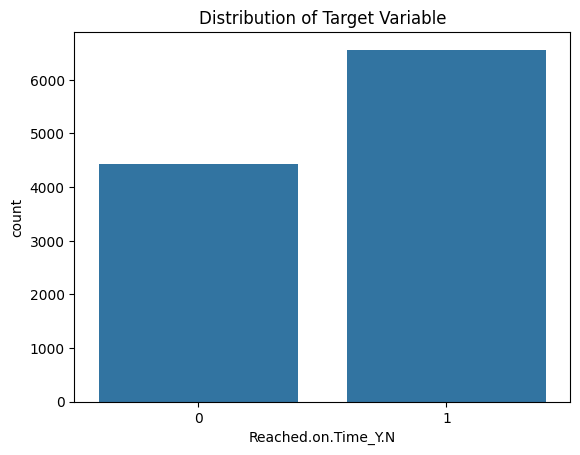

In [4]:
# Distribution of target variable
sns.countplot(x='Reached.on.Time_Y.N', data=data)
plt.title('Distribution of Target Variable')
plt.show()


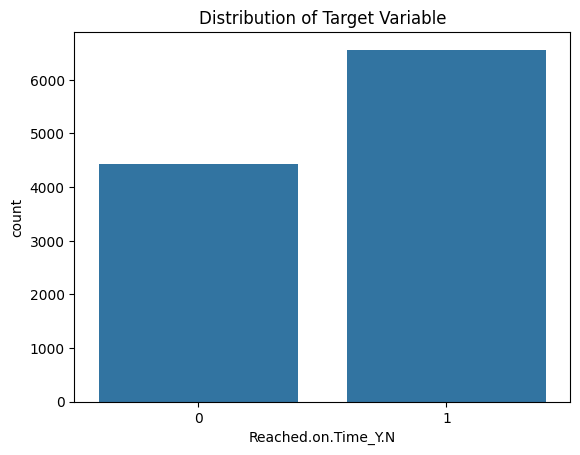

In [5]:
# Distribution of target variable
sns.countplot(x='Reached.on.Time_Y.N', data=data)
plt.title('Distribution of Target Variable')
plt.show()


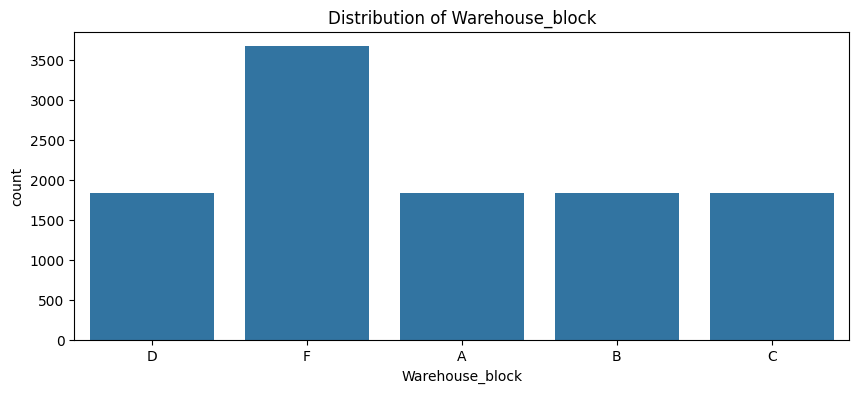

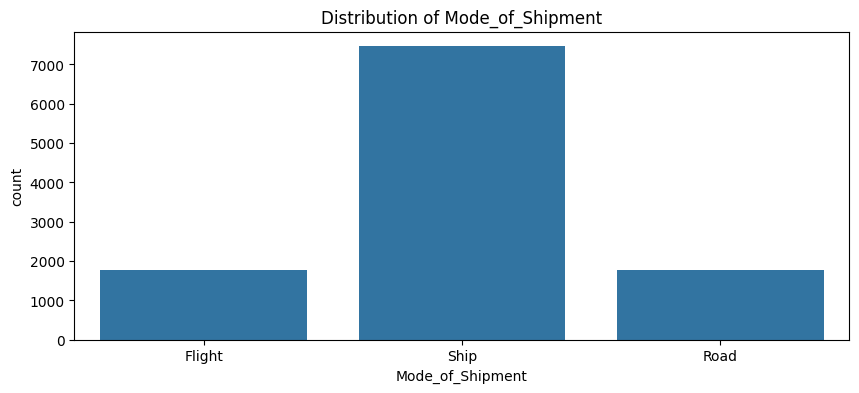

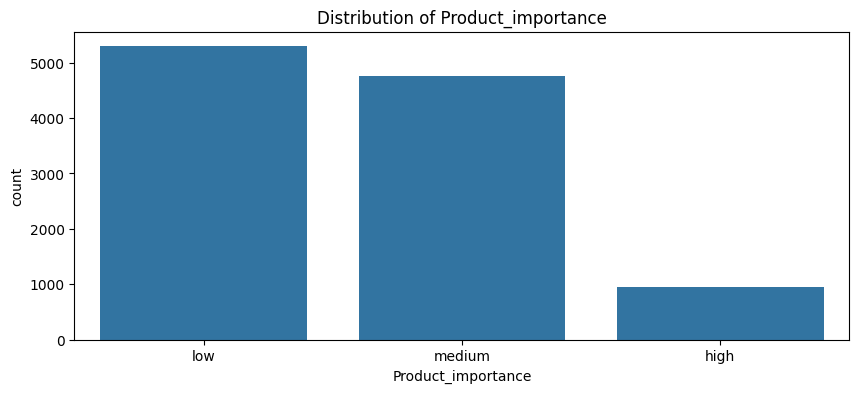

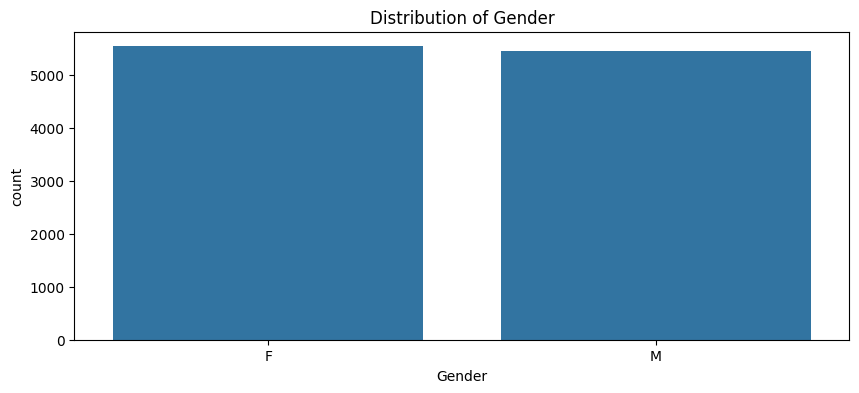

In [6]:
# Count plots for categorical features
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [7]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


NameError: name 'numerical_features' is not defined

<Figure size 1200x800 with 0 Axes>

   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1233            

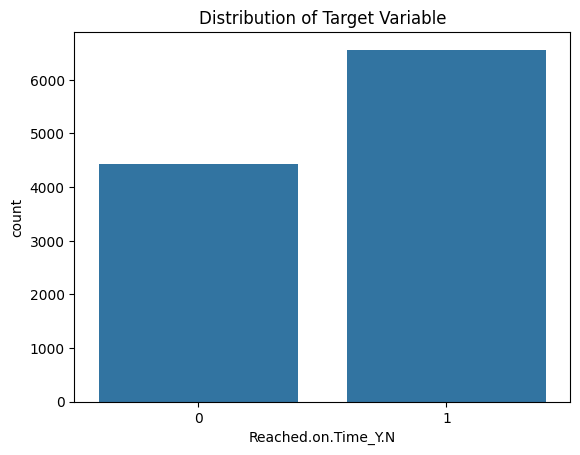

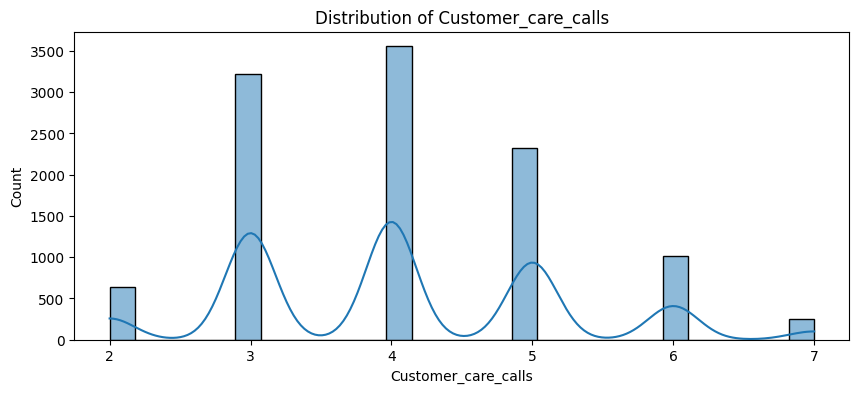

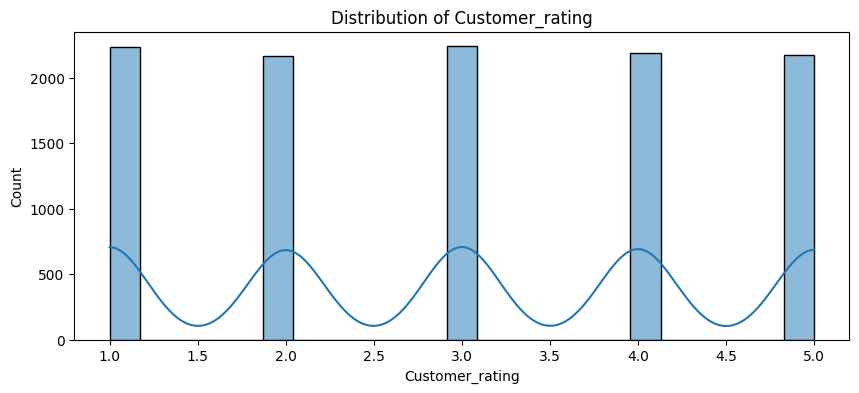

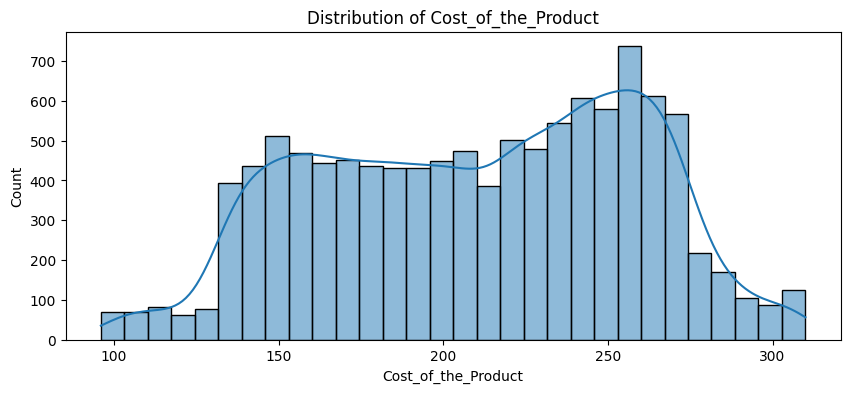

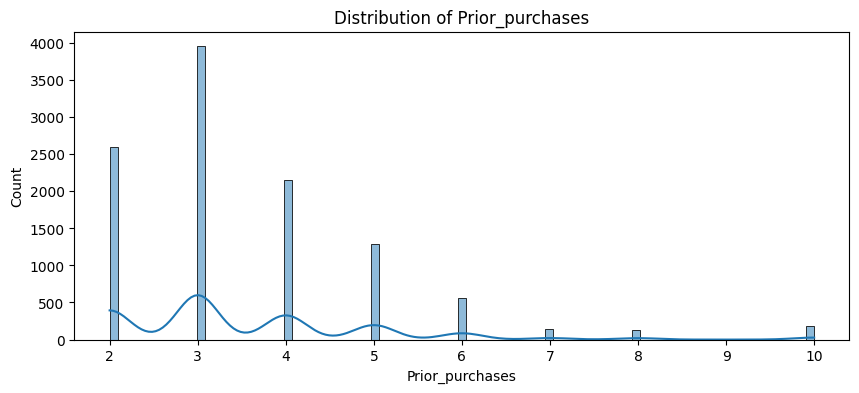

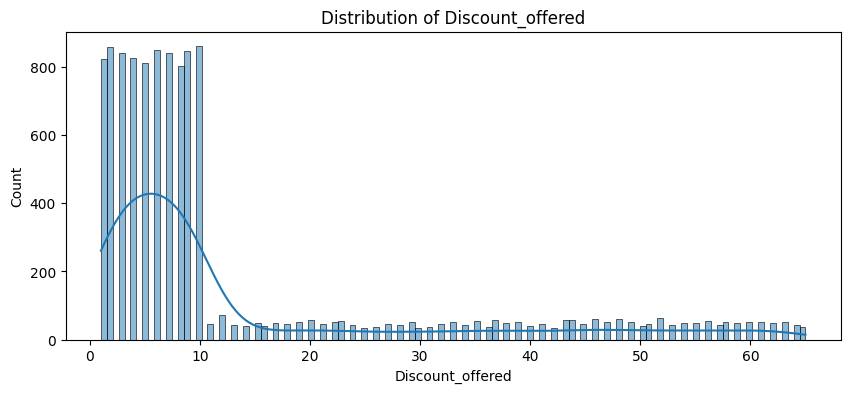

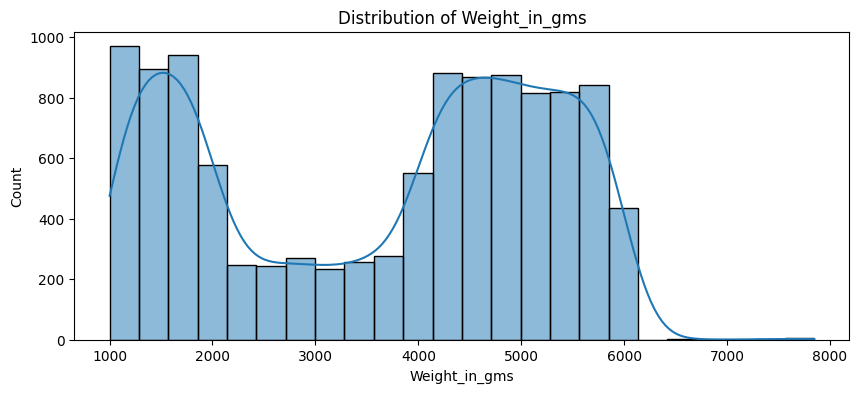

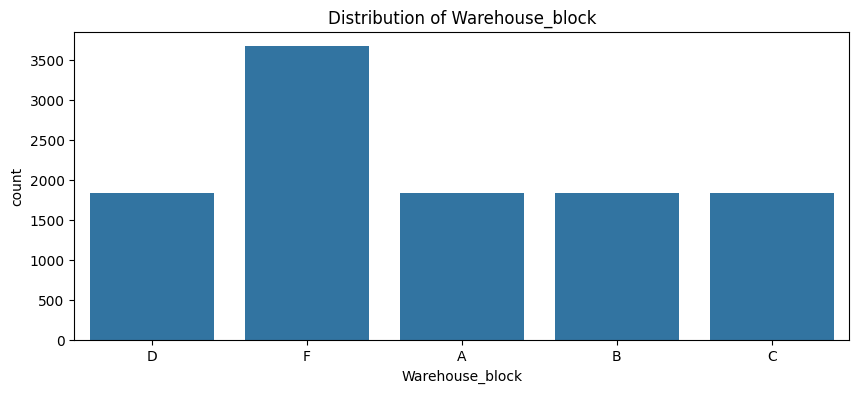

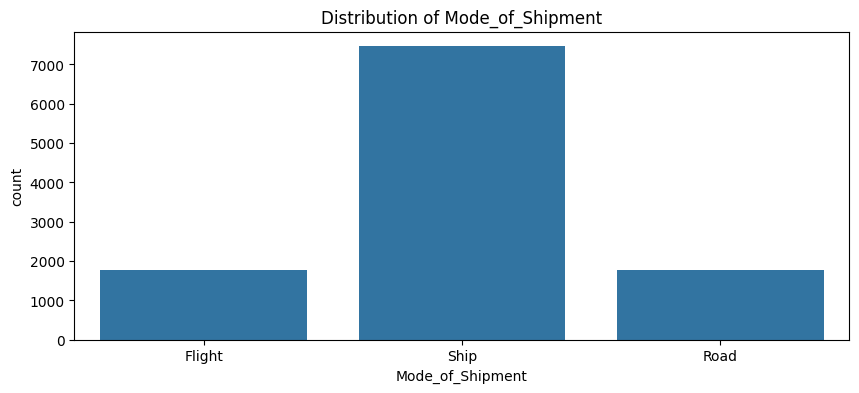

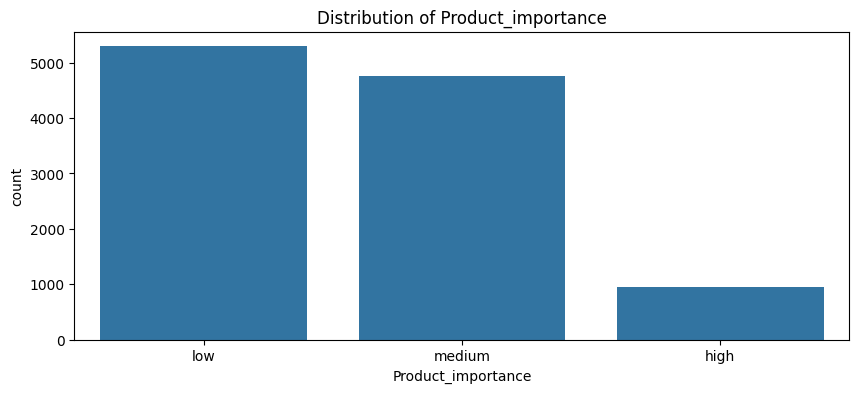

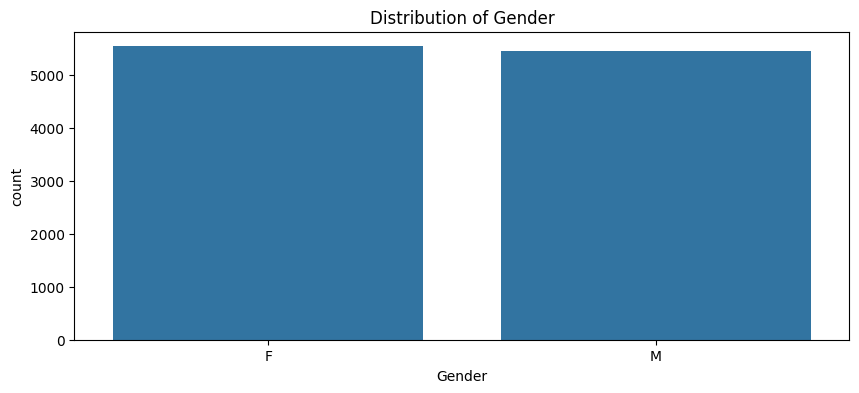

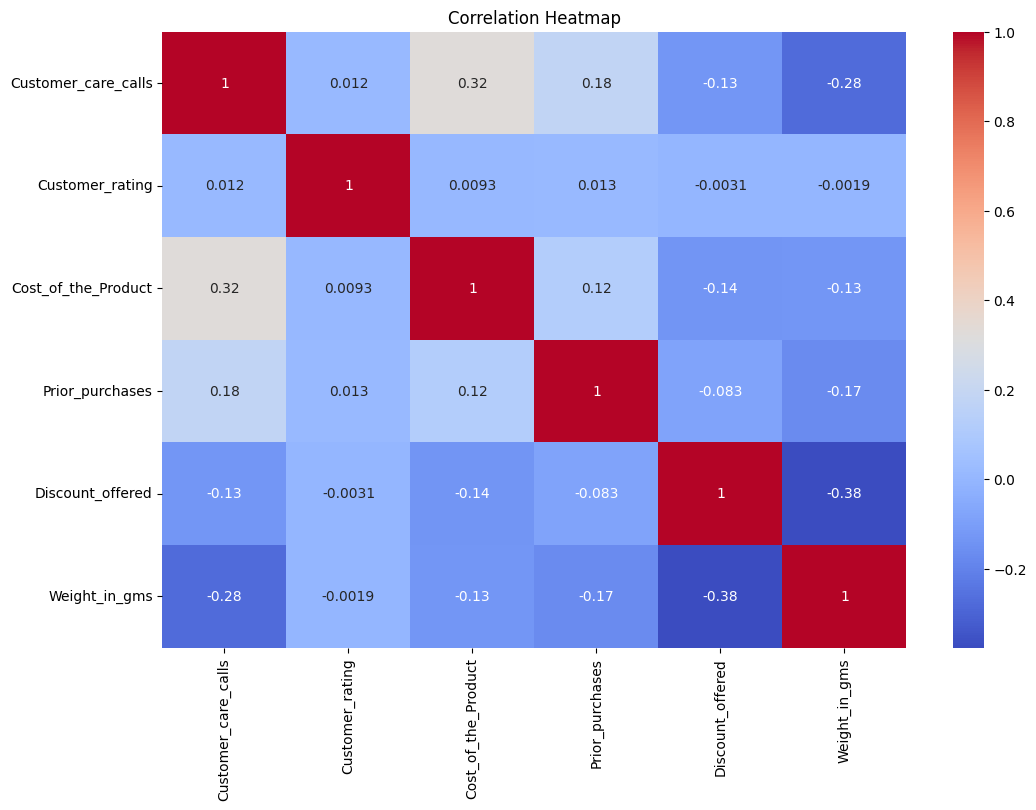

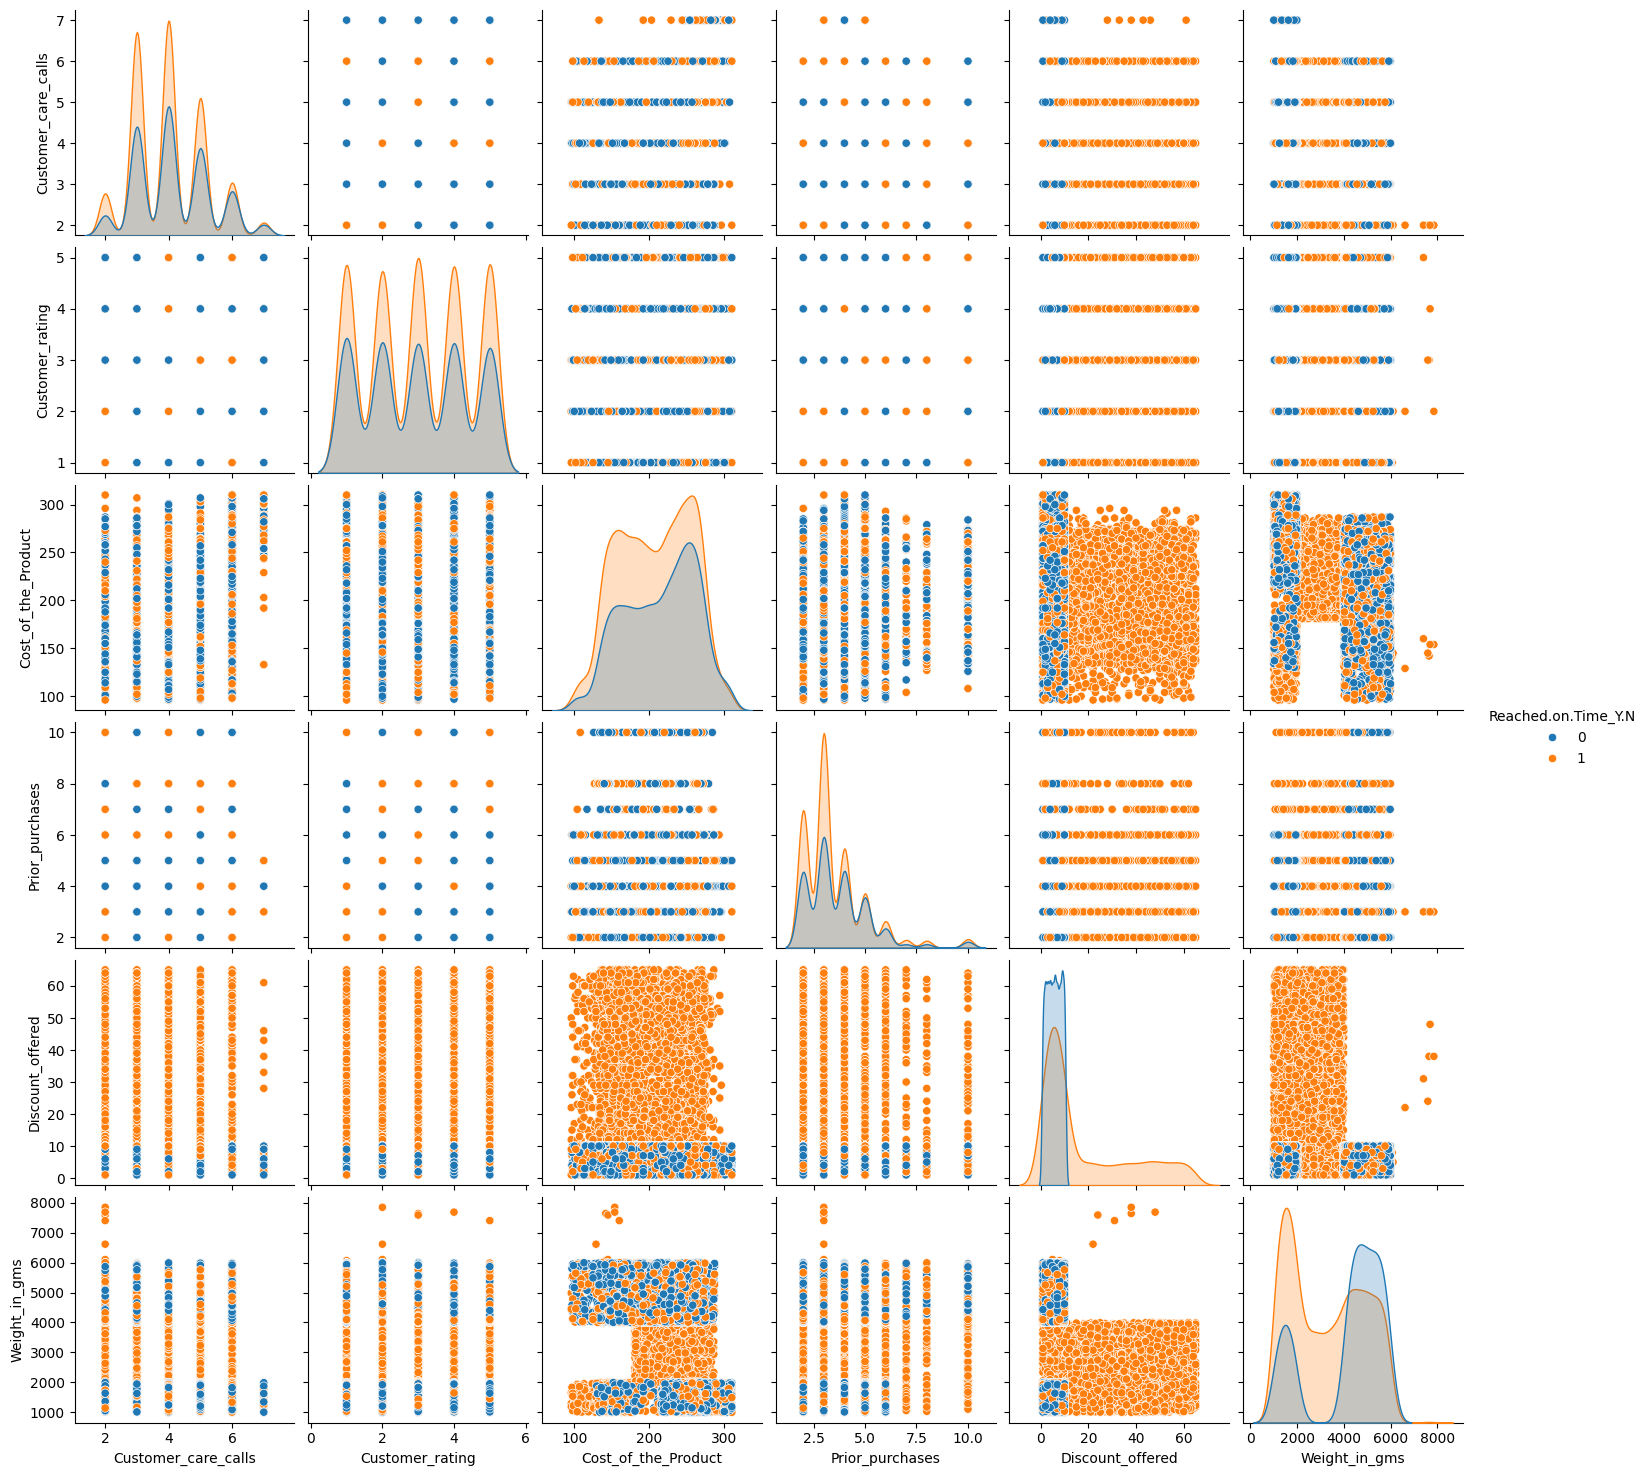

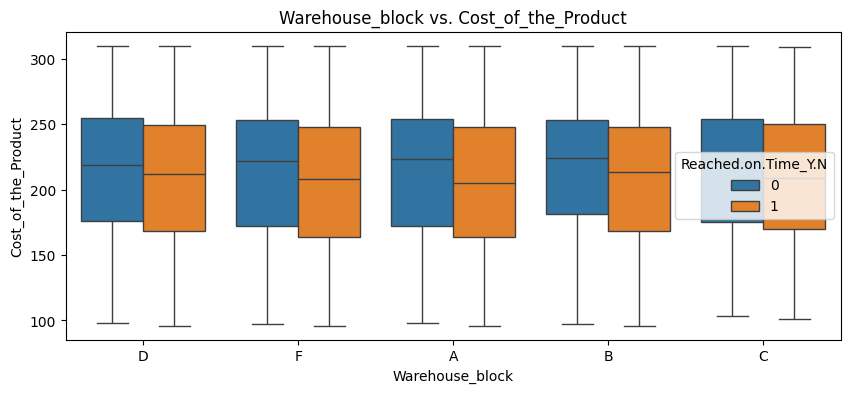

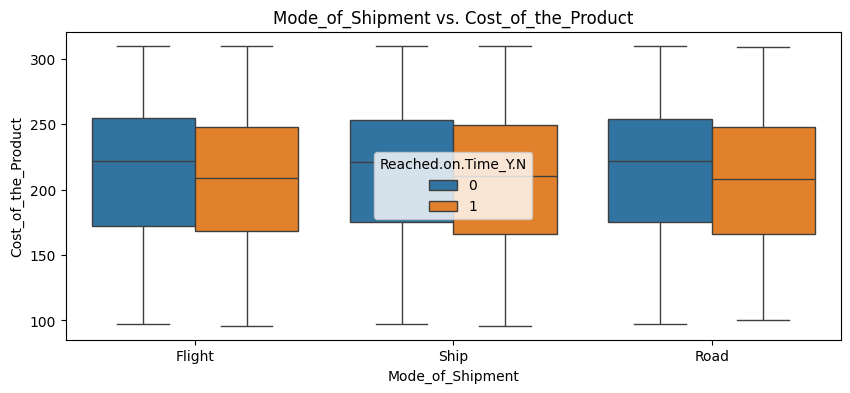

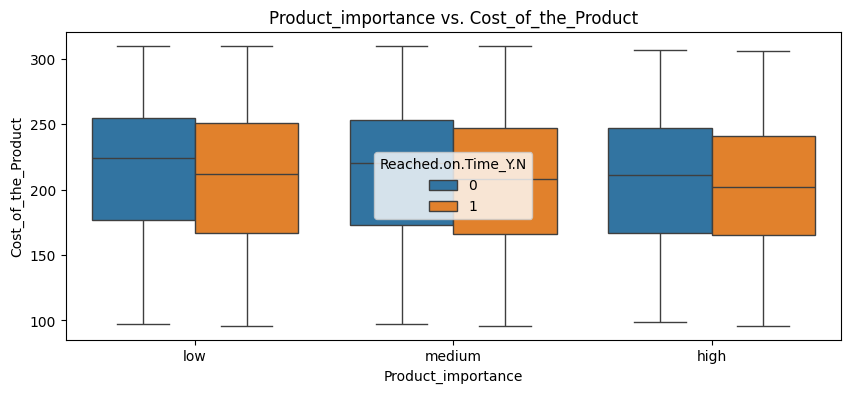

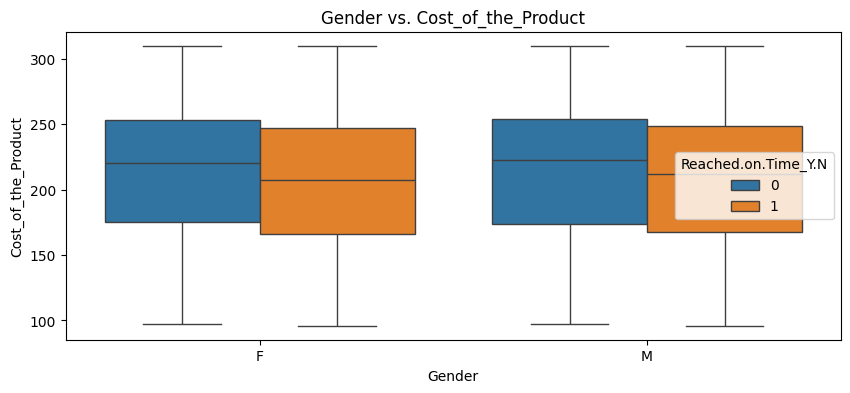

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Train.csv')

# Display the first few rows of the dataset
print(data.head())

# Dataset information
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Summary statistics for numerical features
print(data.describe())

# Summary statistics for categorical features
print(data.describe(include=['O']))

# Distribution of target variable
sns.countplot(x='Reached.on.Time_Y.N', data=data)
plt.title('Distribution of Target Variable')
plt.show()

# Define numerical and categorical features
numerical_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

# Histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Count plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Pairplot for numerical features
sns.pairplot(data[numerical_features + ['Reached.on.Time_Y.N']], hue='Reached.on.Time_Y.N')
plt.show()

# Boxplots for categorical features vs. target variable
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=feature, y='Cost_of_the_Product', hue='Reached.on.Time_Y.N', data=data)
    plt.title(f'{feature} vs. Cost_of_the_Product')
    plt.show()


In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

# Load dataset
data = pd.read_csv('Train.csv')

# Feature engineering
data['Total_Interaction'] = data['Customer_care_calls'] * data['Customer_rating']
data['Cost_per_Weight'] = data['Cost_of_the_Product'] / data['Weight_in_gms']

# Data preprocessing
data = data.fillna(method='ffill')

# Define features and target
X = data.drop(columns=['ID', 'Reached.on.Time_Y.N'])
y = data['Reached.on.Time_Y.N']

# Define numerical and categorical features
numerical_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Total_Interaction', 'Cost_per_Weight']
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess data before applying SMOTE
X_preprocessed = preprocessor.fit_transform(X)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Split resampled data into training and test sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=XGBClassifier(random_state=42), param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_res, y_train_res)

# Best hyperparameters
best_xgb = random_search.best_estimator_

# Update stacking classifier with tuned XGBoost
stacking_clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', best_xgb)
], final_estimator=LogisticRegression())

# Create a pipeline with the stacking classifier
stacking_pipeline = Pipeline(steps=[
    ('classifier', stacking_clf)
])

# Train the ensemble model
stacking_pipeline.fit(X_train_res, y_train_res)

# Evaluate the ensemble model
y_pred = stacking_pipeline.predict(X_test_res)
print(f'Accuracy: {accuracy_score(y_test_res, y_pred)}')
print(classification_report(y_test_res, y_pred))

# Cross-validation
cv_scores = cross_val_score(stacking_pipeline, X_preprocessed, y, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Print best parameters from random search
print("Best parameters found during random search:")
print(random_search.best_params_)

# Serialize the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Serialize the trained stacking pipeline
with open('model.pkl', 'wb') as f:
    pickle.dump(stacking_pipeline, f)


C:\Users\Yash Singh\AppData\Local\Temp\ipykernel_26408\4087570808.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Accuracy: 0.7364813404417365
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1321
           1       0.82      0.60      0.69      1305

    accuracy                           0.74      2626
   macro avg       0.76      0.74      0.73      2626
weighted avg       0.75      0.74      0.73      2626

Cross-validation scores: [0.60181818 0.67090909 0.55636364 0.44909091 0.4306503 ]
Mean cross-validation score: 0.5417664227541444
Best parameters found during random search:
{'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}
